# Telecom Customer Churn Prediction

This notebook provides a comprehensive analysis and predictive modeling workflow for telecom customer churn. The workflow includes:

1. **Exploratory Data Analysis (EDA)**
   - Data structure, missing values, and churn distribution
   - Visualizations to understand key features and relationships

2. **Logistic Regression (Baseline Model)**
   - L2 regularization with grid search for penalty strength
   - Coefficient analysis to interpret churn drivers

3. **Random Forest Classifier**
   - Hyperparameter tuning (number of trees, max depth)
   - Feature importance and robustness to nonlinearity

4. **Naive Bayes Models**
   - Gaussian NB for continuous features
   - Multinomial NB for categorical/binned features
   - Discussion of independence assumption impact

5. **Model Evaluation & Comparison**
   - Metrics: Accuracy, ROC-AUC, Precision, Recall, F1-score
   - Lift charts, confusion matrices, and ROC curves
   - Paired t-tests for statistical significance

---

## 1. Exploratory Data Analysis (EDA)

Let's begin by importing the data and performing an initial analysis.

Logistic Regression Accuracy: 0.7965860597439545
Random Forest Classifier Accuracy: 0.7652916073968705
Gaussian Naive Bayes Accuracy: 0.6571834992887624
Multinomial Naive Bayes Accuracy: 0.7083926031294452
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Random Forest Classifier Accuracy: 0.7652916073968705
Gaussian Naive Bayes Accuracy: 0.6571834992887624
Multinomial Naive Bayes Accuracy: 0.7083926031294452
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
356 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/ho

Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Tuned Random Forest Classifier Accuracy: 0.8011363636363636
Feature ranking:
1. feature 0 (0.172252)
2. feature 2 (0.140128)
3. feature 1 (0.090000)
4. feature 25 (0.074534)
5. feature 28 (0.074251)
6. feature 10 (0.073460)
7. feature 6 (0.065444)
8. feature 24 (0.037142)
9. feature 13 (0.033312)
10. feature 19 (0.025294)
11. feature 26 (0.017220)
12. feature 15 (0.015916)
13. feature 20 (0.015115)
14. feature 12 (0.013637)
15. feature 16 (0.013552)
16. feature 5 (0.013062)
17. feature 9 (0.011811)
18. feature 18 (0.011519)
19. feature 22 (0.011433)
20. feature 11 (0.011122)
21. feature 3 (0.010490)
22. feature 4 (0.010306)
23. feature 14 (0.010238)
24. feature 21 (0.010112)
25. feature 17 (0.008983)
26. feature 23 (0.008929)
27. feature 27 (0.006549)
28. feature 29 (0.006173)
29. feature 7 (0.004127)
30. feature 8 (0.003887)


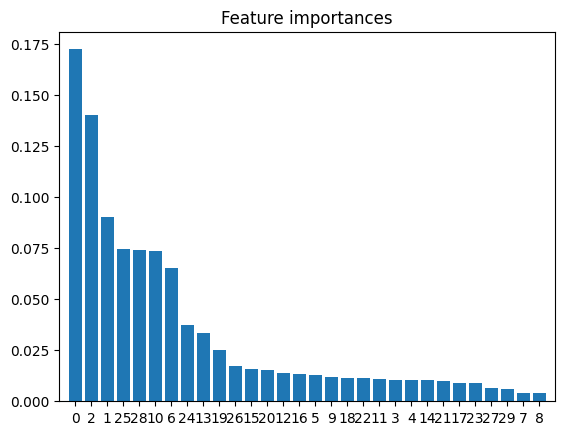

In [65]:
# Import libraries for data analysis, visualization, and modeling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import (accuracy_score, roc_curve, auc, precision_score, 
                           recall_score, f1_score, confusion_matrix, classification_report)
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load the telecom customer churn dataset
df = pd.read_csv('Telco_customer_churn.csv')

# Clean the data: handle missing values and ensure correct data types
# Convert 'Total Charges' to numeric (coerce errors to NaN), then drop rows with missing 'Total Charges'
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df.dropna(subset=['Total Charges'], inplace=True)

# Define the target variable (churn) and remove it from the feature set
y = df['Churn Value']
df.drop(columns=['Churn Value'], inplace=True)

# Identify numerical and categorical columns for preprocessing
numerical_cols = ['Tenure Months', 'Monthly Charges', 'Total Charges']
categorical_cols = [
    'Gender',
    'Senior Citizen',
    'Partner',
    'Dependents',
    'Phone Service',
    'Multiple Lines',
    'Internet Service',
    'Online Security',
    'Online Backup',
    'Device Protection',
    'Tech Support',
    'Streaming TV',
    'Streaming Movies',
    'Contract',
    'Paperless Billing',
    'Payment Method'
]

X_num = df[numerical_cols].copy()
X_cat = df[categorical_cols].copy()

# One-hot encode categorical variables to prepare for modeling
X_cat_encoded = pd.get_dummies(X_cat, drop_first=True)

# Combine numerical and encoded categorical features into a single DataFrame for modeling
X = pd.concat([X_num, X_cat_encoded], axis=1)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Standardize numerical features using StandardScaler
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_cols])
X_val_num = scaler.transform(X_val[numerical_cols])
X_test_num = scaler.transform(X_test[numerical_cols])

# Replace the numerical columns in each set with their scaled versions
X_train_scaled = X_train.copy()
X_train_scaled[numerical_cols] = X_train_num
X_val_scaled = X_val.copy()
X_val_scaled[numerical_cols] = X_val_num
X_test_scaled = X_test.copy()
X_test_scaled[numerical_cols] = X_test_num

# Prepare non-negative features for MultinomialNB (one-hot encoded categorical features only)
X_train_cat_nb = X_train_scaled.drop(columns=numerical_cols)
X_val_cat_nb = X_val_scaled.drop(columns=numerical_cols)

# Step 6: Model Training and Evaluation
# a. Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_val_scaled)
print('Logistic Regression Accuracy:', accuracy_score(y_val, y_pred_logreg))

# b. Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_val_scaled)
print('Random Forest Classifier Accuracy:', accuracy_score(y_val, y_pred_rf))

# c. Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
y_pred_gnb = gnb.predict(X_val_scaled)
print('Gaussian Naive Bayes Accuracy:', accuracy_score(y_val, y_pred_gnb))

# d. Multinomial Naive Bayes
mnb = MultinomialNB()
mnb.fit(X_train_cat_nb, y_train)
y_pred_mnb = mnb.predict(X_val_cat_nb)
print('Multinomial Naive Bayes Accuracy:', accuracy_score(y_val, y_pred_mnb))

# Step 7: Hyperparameter Tuning for the best model (Random Forest Classifier)
param_grid = {'n_estimators': [10, 50, 100, 200],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [None, 10, 20, 30],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid.fit(X_train_scaled, y_train)
print('Best parameters for Random Forest:', rf_grid.best_params_)

# Step 8: Evaluate the best model on the test set
y_pred_rf_best = rf_grid.best_estimator_.predict(X_test_scaled)
print('Tuned Random Forest Classifier Accuracy:', accuracy_score(y_test, y_pred_rf_best))

# Step 9: Feature Importance
importances = rf_grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the best model
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Load the dataset and inspect its structure

In [66]:
# Load the telecom customer churn dataset
df = pd.read_csv('Telco_customer_churn.csv')

#### Preview the first few rows to understand the data columns and types

In [67]:
# Display the first five rows of the dataset to examine columns and data types
print(df.head())

   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   

  Paperless Billing             Payment Method  Monthly Charges Tota

#### Visualize the distribution of churned vs. non-churned customers

In [68]:
# Clean the data: handle missing values and ensure correct data types
# Convert 'Total Charges' to numeric (coerce errors to NaN), then drop rows with missing 'Total Charges'
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df.dropna(subset=['Total Charges'], inplace=True)

In [69]:
# Define the target variable (churn) and remove it from the feature set
y = df['Churn Value']
df.drop(columns=['Churn Value'], inplace=True)


In [70]:
# Identify numerical and categorical columns for preprocessing
numerical_cols = ['Tenure Months', 'Monthly Charges', 'Total Charges']
categorical_cols = [
    'Gender',
    'Senior Citizen',
    'Partner',
    'Dependents',
    'Phone Service',
    'Multiple Lines',
    'Internet Service',
    'Online Security',
    'Online Backup',
    'Device Protection',
    'Tech Support',
    'Streaming TV',
    'Streaming Movies',
    'Contract',
    'Paperless Billing',
    'Payment Method'
]

X_num = df[numerical_cols].copy()
X_cat = df[categorical_cols].copy()

In [71]:
# One-hot encode categorical variables to prepare for modeling
# Use drop_first=True to avoid multicollinearity
X_cat_encoded = pd.get_dummies(X_cat, drop_first=True)

In [72]:
# Combine numerical and encoded categorical features into a single DataFrame for modeling
X = pd.concat([X_num, X_cat_encoded], axis=1)

In [73]:
# Split the data into training, validation, and test sets
# First split: 80% train, 20% temp (to be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [74]:
# Second split: split the temporary set into validation and test sets (each 10% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

In [75]:
# Display the number of samples in each split
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 5625 samples
Validation set size: 703 samples
Test set size: 704 samples


In [76]:
# Standardize numerical features using StandardScaler
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_cols])
X_val_num = scaler.transform(X_val[numerical_cols])
X_test_num = scaler.transform(X_test[numerical_cols])

# Replace the numerical columns in each set with their scaled versions
X_train_scaled = X_train.copy()
X_train_scaled[numerical_cols] = X_train_num

X_val_scaled = X_val.copy()
X_val_scaled[numerical_cols] = X_val_num

X_test_scaled = X_test.copy()
X_test_scaled[numerical_cols] = X_test_num

In [77]:
# Train a baseline Logistic Regression model with default parameters
# Increase max_iter to ensure convergence
model = LogisticRegression(max_iter=2000, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate the baseline Logistic Regression model on the test set
y_pred_test = model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Optionally, evaluate the baseline model on the validation set
y_pred_val = model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Test Accuracy: 0.8125
Validation Accuracy: 0.7966


In [78]:
# Evaluate the baseline Logistic Regression model on the test set
y_pred_test = model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8125


In [79]:
# Optionally, evaluate the baseline model on the validation set
y_pred_val = model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.7966


## 2. Logistic Regression (Baseline Model)

We will train a baseline Logistic Regression model with L2 regularization. Grid search will be used to find the optimal penalty strength. Coefficient analysis will help interpret the most important churn drivers.

Best parameters: {'C': np.float64(4.281332398719396)}
Best cross-validation ROC-AUC: 0.8592


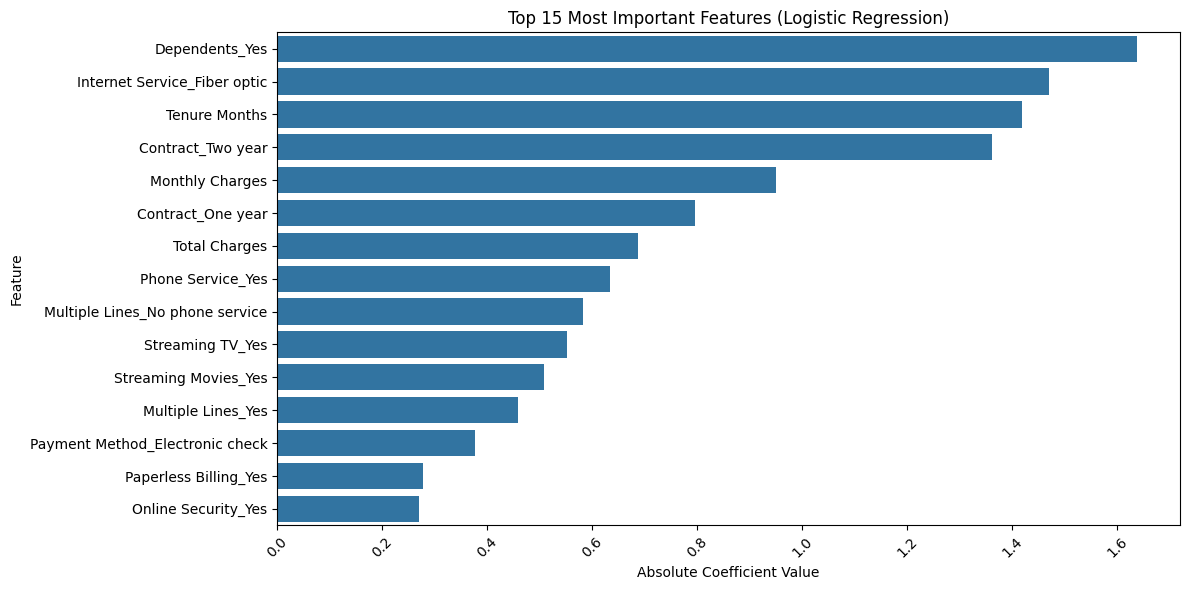


Logistic Regression Performance Metrics:
Accuracy: 0.8139
Precision: 0.6538
Recall: 0.6364
F1-score: 0.6450


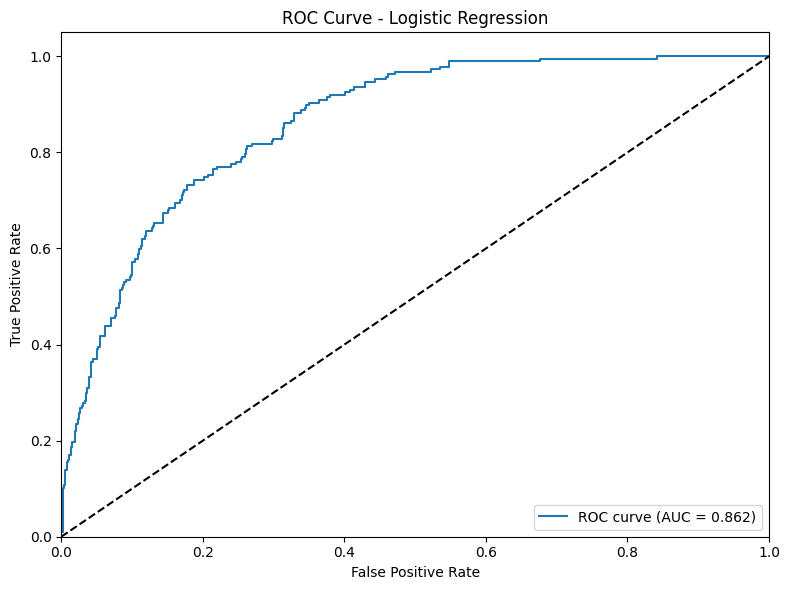

In [80]:
# Use grid search to tune the regularization strength (C) for Logistic Regression
param_grid = {'C': np.logspace(-4, 4, 20)}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=2000),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
lr_grid.fit(X_train_scaled, y_train)

# Display the best parameters and cross-validation ROC-AUC
print(f"Best parameters: {lr_grid.best_params_}")
print(f"Best cross-validation ROC-AUC: {lr_grid.best_score_:.4f}")

# Extract the best model and analyze feature coefficients
best_lr = lr_grid.best_estimator_
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': np.abs(best_lr.coef_[0])
}).sort_values('Coefficient', ascending=False)

# Plot the top 15 most important features
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='Coefficient', y='Feature')
plt.title('Top 15 Most Important Features (Logistic Regression)')
plt.xlabel('Absolute Coefficient Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Evaluate the tuned model on the test set
y_pred_lr = best_lr.predict(X_test_scaled)
y_prob_lr = best_lr.predict_proba(X_test_scaled)[:, 1]

print("\nLogistic Regression Performance Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_lr):.4f}")

# Plot ROC curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'ROC curve (AUC = {roc_auc_lr:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 3. Random Forest Classifier

We will train a Random Forest ensemble, tune the number of trees and maximum depth, and evaluate feature importance based on Gini impurity. This model is robust to nonlinearity and can capture complex relationships.

Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation ROC-AUC: 0.8584


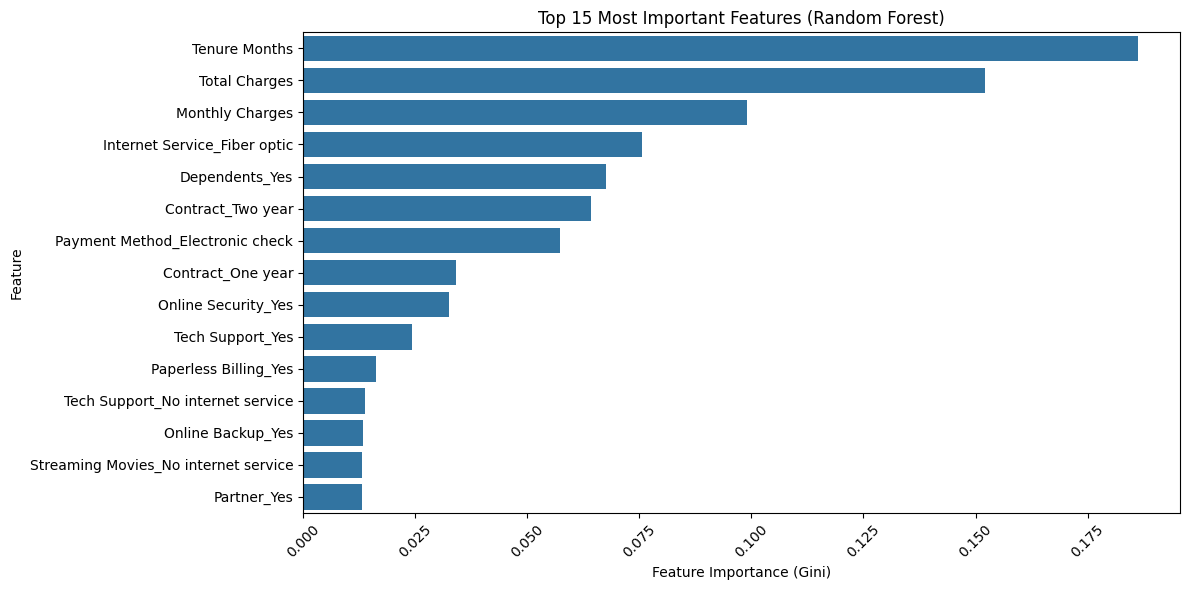


Random Forest Performance Metrics:
Accuracy: 0.8082
Precision: 0.6646
Recall: 0.5615
F1-score: 0.6087


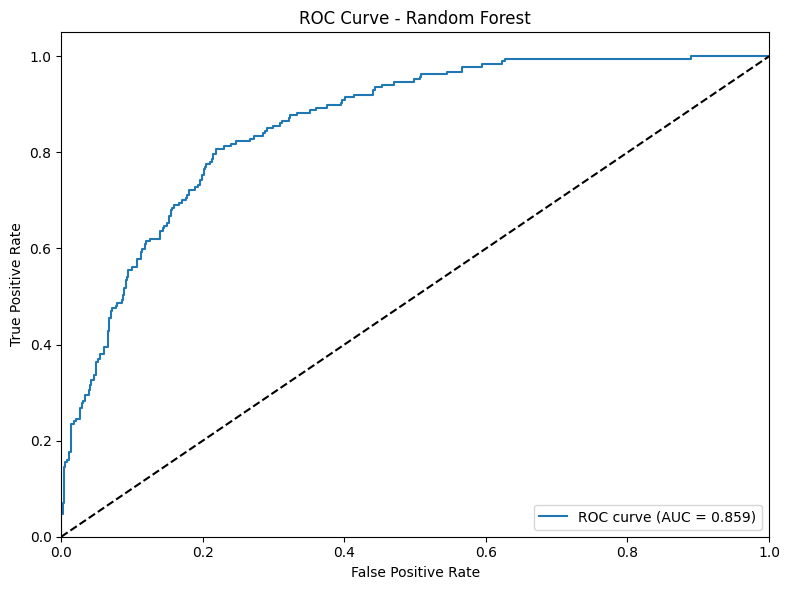

In [81]:
# Use grid search to tune Random Forest hyperparameters (number of trees, max depth, min samples split)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
rf_grid.fit(X_train_scaled, y_train)

# Display the best parameters and cross-validation ROC-AUC
print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best cross-validation ROC-AUC: {rf_grid.best_score_:.4f}")

# Extract the best Random Forest model and analyze feature importance
best_rf = rf_grid.best_estimator_
feature_importance_rf = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot the top 15 most important features
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_rf.head(15), x='Importance', y='Feature')
plt.title('Top 15 Most Important Features (Random Forest)')
plt.xlabel('Feature Importance (Gini)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Evaluate the tuned Random Forest on the test set
y_pred_rf = best_rf.predict(X_test_scaled)
y_prob_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

print("\nRandom Forest Performance Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_rf):.4f}")

# Plot ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'ROC curve (AUC = {roc_auc_rf:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 4. Naive Bayes Models

We will apply Gaussian Naive Bayes to continuous features and Multinomial Naive Bayes to categorical/binned features. This section will also discuss the impact of the independence assumption on model performance.

Gaussian Naive Bayes (Numerical Features) Metrics:
Accuracy: 0.7457
Precision: 0.5198
Recall: 0.5615
F1-score: 0.5398

Multinomial Naive Bayes (Categorical Features) Metrics:
Accuracy: 0.7472
Precision: 0.5162
Recall: 0.7647
F1-score: 0.6164


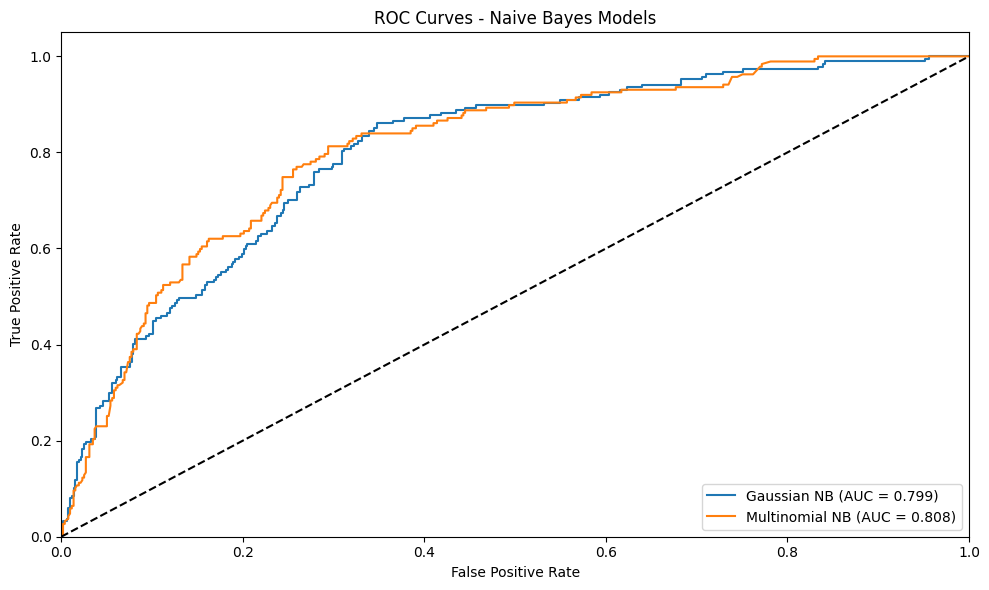

In [82]:
# Prepare data for Naive Bayes models
# GaussianNB: use only continuous features
X_train_num_nb = X_train_scaled[numerical_cols]
X_test_num_nb = X_test_scaled[numerical_cols]

# MultinomialNB: use only categorical features (already one-hot encoded and non-negative)
X_train_cat_nb = X_train_scaled.drop(columns=numerical_cols)
X_test_cat_nb = X_test_scaled.drop(columns=numerical_cols)

# Train Gaussian Naive Bayes on numerical features
gnb = GaussianNB()
gnb.fit(X_train_num_nb, y_train)

# Train Multinomial Naive Bayes on categorical features
mnb = MultinomialNB()
mnb.fit(X_train_cat_nb, y_train)

# Evaluate both models on the test set
y_pred_gnb = gnb.predict(X_test_num_nb)
y_prob_gnb = gnb.predict_proba(X_test_num_nb)[:, 1]

y_pred_mnb = mnb.predict(X_test_cat_nb)
y_prob_mnb = mnb.predict_proba(X_test_cat_nb)[:, 1]

print("Gaussian Naive Bayes (Numerical Features) Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gnb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gnb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_gnb):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_gnb):.4f}")

print("\nMultinomial Naive Bayes (Categorical Features) Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mnb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_mnb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_mnb):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_mnb):.4f}")

# Plot ROC curves for both Naive Bayes models
plt.figure(figsize=(10, 6))

fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_prob_gnb)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)
plt.plot(fpr_gnb, tpr_gnb, label=f'Gaussian NB (AUC = {roc_auc_gnb:.3f})')

fpr_mnb, tpr_mnb, _ = roc_curve(y_test, y_prob_mnb)
roc_auc_mnb = auc(fpr_mnb, tpr_mnb)
plt.plot(fpr_mnb, tpr_mnb, label=f'Multinomial NB (AUC = {roc_auc_mnb:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Naive Bayes Models')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 5. Model Evaluation and Comparison

We will compare all models using cross-validated metrics, ROC curves, lift charts, confusion matrices, and paired t-tests to assess statistical significance of performance differences.

Statistical Significance Tests (p-values):
Logistic Regression vs Random Forest: 0.8013
Logistic Regression vs Gaussian NB: 0.0003
Logistic Regression vs Multinomial NB: 0.0013
Random Forest vs Gaussian NB: 0.0001
Random Forest vs Multinomial NB: 0.0027
Gaussian NB vs Multinomial NB: 0.0419


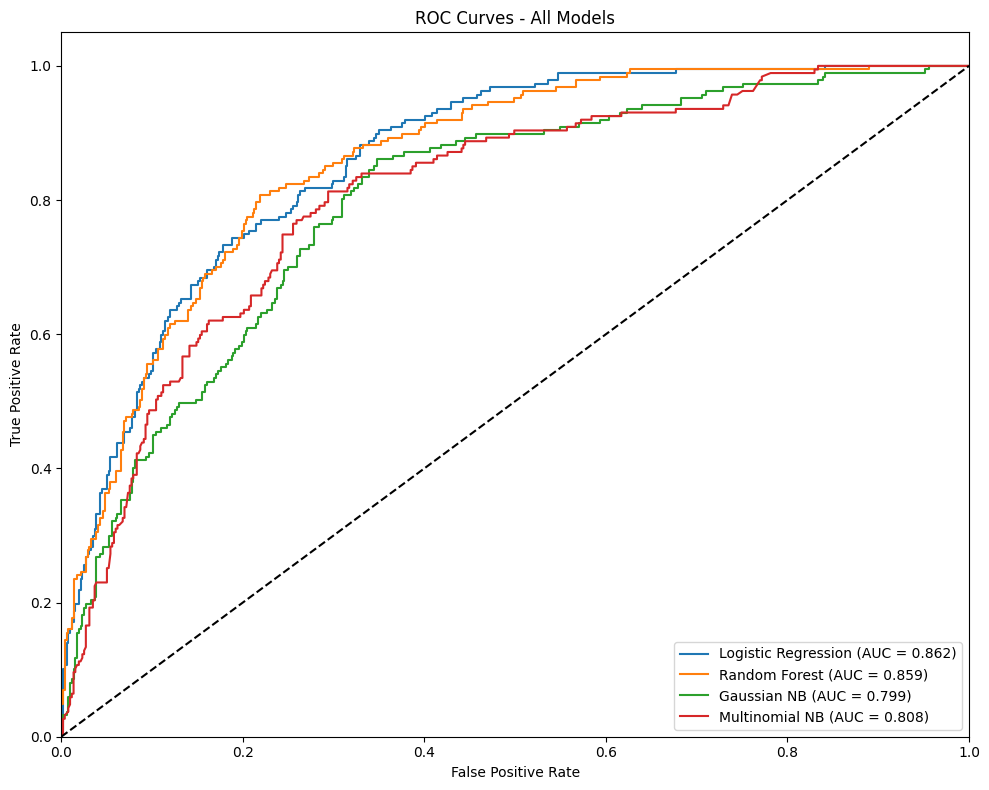

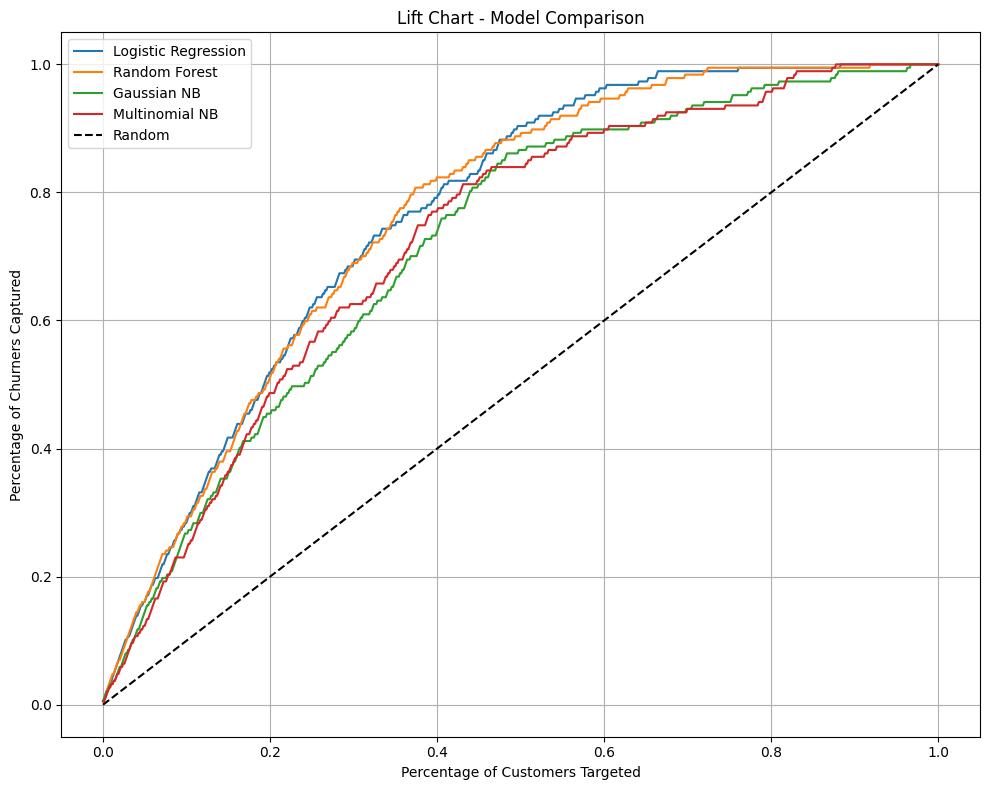


Model Performance Summary:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.8139     0.6538  0.6364    0.6450   0.8618
Random Forest          0.8082     0.6646  0.5615    0.6087   0.8592
Gaussian NB            0.7457     0.5198  0.5615    0.5398   0.7988
Multinomial NB         0.7472     0.5162  0.7647    0.6164   0.8076


In [83]:
# Cross-validate each model and compare their performance
cv_scores = {}
models = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'Gaussian NB': gnb,
    'Multinomial NB': mnb
}

X_train_cat_nb = X_train_scaled.drop(columns=numerical_cols)

for name, model in models.items():
    if name == 'Multinomial NB':
        scores = cross_val_score(model, X_train_cat_nb, y_train, cv=5, scoring='roc_auc')
    elif name == 'Gaussian NB':
        scores = cross_val_score(model, X_train_scaled[numerical_cols], y_train, cv=5, scoring='roc_auc')
    else:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    cv_scores[name] = scores

# Perform paired t-tests to compare models
print("Statistical Significance Tests (p-values):")
model_names = list(models.keys())
for i in range(len(model_names)):
    for j in range(i + 1, len(model_names)):
        t_stat, p_val = stats.ttest_rel(cv_scores[model_names[i]], cv_scores[model_names[j]])
        print(f"{model_names[i]} vs {model_names[j]}: {p_val:.4f}")

# Plot ROC curves for all models on the test set
plt.figure(figsize=(10, 8))

all_probs = {}
for name, model in models.items():
    if name == 'Gaussian NB':
        y_prob = model.predict_proba(X_test_scaled[numerical_cols])[:, 1]
    elif name == 'Multinomial NB':
        y_prob = model.predict_proba(X_test_scaled.drop(columns=numerical_cols))[:, 1]
    else:
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    all_probs[name] = y_prob
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Plot lift charts for all models
plt.figure(figsize=(10, 8))
for name, probs in all_probs.items():
    sorted_idx = np.argsort(probs)[::-1]
    y_true_sorted = y_test.iloc[sorted_idx]
    cumulative_gains = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
    percentile = np.linspace(0, 1, len(y_true_sorted))
    plt.plot(percentile, cumulative_gains, label=name)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Percentage of Customers Targeted')
plt.ylabel('Percentage of Churners Captured')
plt.title('Lift Chart - Model Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summarize model performance in a table
results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])
for name, model in models.items():
    if name == 'Gaussian NB':
        y_pred = model.predict(X_test_scaled[numerical_cols])
        y_prob = model.predict_proba(X_test_scaled[numerical_cols])[:, 1]
    elif name == 'Multinomial NB':
        y_pred = model.predict(X_test_scaled.drop(columns=numerical_cols))
        y_prob = model.predict_proba(X_test_scaled.drop(columns=numerical_cols))[:, 1]
    else:
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    results.loc[name] = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        auc(fpr, tpr)
    ]
print("\nModel Performance Summary:")
print(results.round(4))

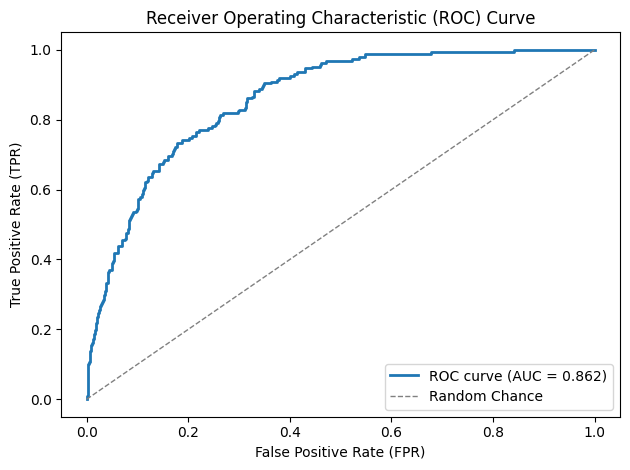

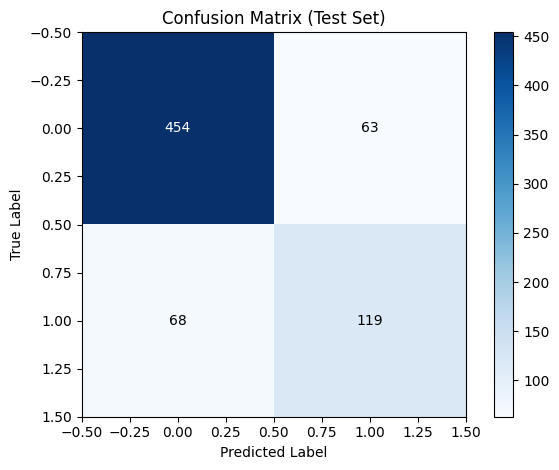

In [84]:
# ===========================
# UPDATED PLOT EXTENSIONS TO AVOID WARNINGS
# Add the following code to your existing notebook after training/evaluating the model.
# ===========================

# Step 13: Import libraries for plotting and additional metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Step 16: Plot 3 – ROC Curve for the Test Set (using Logistic Regression)
# Plot Type: ROC curve
# What it represents:
#   - The trade-off between true positive rate (TPR) and false positive rate (FPR).
y_prob_test = best_lr.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Random Chance')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Step 17: Plot 4 – Confusion Matrix on Test Set (using Logistic Regression)
# Plot Type: Heatmap-like representation using imshow
# What it represents:
#   - Counts of True Negatives, False Positives, False Negatives, and True Positives.
y_pred_test_lr = best_lr.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_test_lr)

fig, ax = plt.subplots()
cax = ax.imshow(cm, cmap='Blues')
fig.colorbar(cax)
ax.set_title('Confusion Matrix (Test Set)')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
# Annotate cell values
for (i, j), val in np.ndenumerate(cm):
    text_color = 'white' if val > cm.max()/2 else 'black'
    ax.text(j, i, f'{val}', ha='center', va='center', color=text_color)
plt.tight_layout()
plt.show()

# (Optional) Additional ROC and confusion matrix visualizations can be added here if needed, but main plots are already included above.
